## 3. Forest Cover Type Dataset  
- Multi-Class LGBM CV and Seed Diversification

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right\"> Initial upload: 2021.9.24 </div>
<div style="text-align: right\"> Last update: 2021.9.24</div>

- 출처 : https://www.kaggle.com/uciml/forest-cover-type-dataset

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

from scipy.signal import find_peaks

In [2]:
colors = ["#00798c", "#d1495b", '#edae49', '#66a182', '#4a4a4a',
          '#1a508b', '#e3120b', '#c5a880', '#9F5F80', '#6F9EAF',
          '#0278ae','#F39233', '#A7C5EB', '#54E346', '#ABCE74',
        '#d6b0b1', '#58391c', '#cdd0cb', '#ffb396', '#6930c3']
sns.color_palette(colors[:10])

[(0.0, 0.4745098039215686, 0.5490196078431373),
 (0.8196078431372549, 0.28627450980392155, 0.3568627450980392),
 (0.9294117647058824, 0.6823529411764706, 0.28627450980392155),
 (0.4, 0.6313725490196078, 0.5098039215686274),
 (0.2901960784313726, 0.2901960784313726, 0.2901960784313726),
 (0.10196078431372549, 0.3137254901960784, 0.5450980392156862),
 (0.8901960784313725, 0.07058823529411765, 0.043137254901960784),
 (0.7725490196078432, 0.6588235294117647, 0.5019607843137255),
 (0.6235294117647059, 0.37254901960784315, 0.5019607843137255),
 (0.43529411764705883, 0.6196078431372549, 0.6862745098039216)]

Contains:

- Data Load
- Feature Engineering
- Exploratory Data Analysis
- Light GBM Cross Validation
- Seed Diversification
- Feature Importance

Load

In [3]:
import time
import os, gc, random, re

In [4]:
random.seed(2018)

In [5]:
# Models Packages
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from IPython.display import display

In [6]:
# Gradient Boosting
import lightgbm as lgb

In [7]:
# Text Models
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [24]:
import matplotlib as mpl
from wordcloud import WordCloud, STOPWORDS

In [10]:
# TSNE
from yellowbrick.text import TSNEVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
# Specify index/ target name
id_col = "Id"
target_var = "Cover_Type"

# House Keeping Parameters
Debug = False
Home = False
Build_Results_csv = False # if running for first time at Home

In [12]:
results = pd.DataFrame(columns = ["Rounds","Score","STDV", "LB", "Parameters"])
if Build_Results_csv is True & Home is True: results.to_csv("results.csv")
if Home is True:
    import os
    path = r"D:\My Computer\DATA\Forest Cover"
    os.chdir(path)
    
    print("Data Load Stage")
    training = pd.read_csv('train.csv', index_col = id_col)
    if Debug is True : training = training.sample(500)
    traindex = training.index
    testing = pd.read_csv('test.csv', index_col = id_col)
    if Debug is True : testing = testing.sample(500)
    testdex = testing.index
else:
    print("Data Load Stage")
    training = pd.read_csv('./data/forest-cover-type-kernels-only/train.csv', index_col = id_col)
    if Debug is True : training = training.sample(100)
    traindex = training.index
    testing = pd.read_csv('./data/forest-cover-type-kernels-only/test.csv', index_col = id_col)
    if Debug is True : testing = testing.sample(100)
    testdex = testing.index
    
y = training[target_var]
training.drop(target_var,axis=1, inplace=True)
print('Train shape: {} Rows, {} Columns'.format(*training.shape))
print('Test shape: {} Rows, {} Columns'.format(*testing.shape))

print("Combine Train and Test")
df = pd.concat([training,testing],axis=0)
del training, testing
gc.collect()
print('\nAll Data shape: {} Rows, {} Columns'.format(*df.shape))

Data Load Stage
Train shape: 15120 Rows, 54 Columns
Test shape: 565892 Rows, 54 Columns
Combine Train and Test

All Data shape: 581012 Rows, 54 Columns


In [13]:
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
Id,,,,,,,,,,,,,,,,,,,,,
1,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,0
2,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,0
3,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,0
4,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,0
5,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,0


In [14]:
y.head()

Id
1    5
2    5
3    2
4    2
5    5
Name: Cover_Type, dtype: int64

**Class Distribution:**  
This is crucial for all classification problems. Since unbalanced classes must be delt with the appropriate metrics, re-sampling, and stratification methods.

In [15]:
y.value_counts()

1    2160
2    2160
3    2160
4    2160
5    2160
6    2160
7    2160
Name: Cover_Type, dtype: int64

In [16]:
y_trees = y.map({1: "Spruce/Fir", 2: "Lodgepole Pine", 3: "Ponderosa Pine",
                 4: "Cottonwood/Willow",5:"Aspen",6:"Douglas-fir",7:"Krummholz"})
print("Percent Class Distribution:")
print(y_trees.value_counts(normalize=True)*100)
display(df.head())

Percent Class Distribution:
Krummholz            14.285714
Ponderosa Pine       14.285714
Spruce/Fir           14.285714
Douglas-fir          14.285714
Cottonwood/Willow    14.285714
Aspen                14.285714
Lodgepole Pine       14.285714
Name: Cover_Type, dtype: float64


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
Id,,,,,,,,,,,,,,,,,,,,,
1,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,0
2,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,0
3,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,0
4,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,0
5,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,0


- classes are balanced

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 581012 entries, 1 to 581012
Data columns (total 54 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

In [19]:
df[df.columns[14:]]

,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
Id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581008,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581009,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581010,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Feature engineering  
- Time Difference Features
- Product of Elevation and Slope
- Bag-Of-Words on Soil Description
- Lathwal Distance Features

In [20]:
print("Engineering Text Features:")
# Shade Difference
df["Hillshade-9_Noon_diff"] = df["Hillshade_9am"] - df["Hillshade_Noon"]
df["Hillshade-noon_3pm_diff"] = df["Hillshade_Noon"] - df["Hillshade_3pm"]
df["Hillshade-9am_3pm_diff"] = df["Hillshade_9am"] - df["Hillshade_3pm"]

# Mountain Trees
df["Slope*Elevation"] = df["Slope"] * df["Elevation"] # Only some trees can grow on steep montain tops

# Text Features from Description
soil_descriptions = {
    1: "Cathedral family - Rock outcrop complex, extremely stony.",
    2: "Vanet - Ratake families complex, very stony.",
    3: "Haploborolis - Rock outcrop complex, rubbly.",
    4: "Ratake family - Rock outcrop complex, rubbly.",
    5: "Vanet family - Rock outcrop complex complex, rubbly.",
    6: "Vanet - Wetmore families - Rock outcrop complex, stony.",
    7: "Gothic family.",
    8: "Supervisor - Limber families complex.",
    9: "Troutville family, very stony.",
    10: "Bullwark - Catamount families - Rock outcrop complex, rubbly.",
    11: "Bullwark - Catamount families - Rock land complex, rubbly.",
    12: "Legault family - Rock land complex, stony.",
    13: "Catamount family - Rock land - Bullwark family complex, rubbly.",
    14: "Pachic Argiborolis - Aquolis complex.",
    15: "unspecified in the USFS Soil and ELU Survey.",
    16: "Cryaquolis - Cryoborolis complex.",
    17: "Gateview family - Cryaquolis complex.",
    18: "Rogert family, very stony.",
    19: "Typic Cryaquolis - Borohemists complex.",
    20: "Typic Cryaquepts - Typic Cryaquolls complex.",
    21: "Typic Cryaquolls - Leighcan family, till substratum complex.",
    22: "Leighcan family, till substratum, extremely bouldery.",
    23: "Leighcan family, till substratum - Typic Cryaquolls complex.",
    24: "Leighcan family, extremely stony.",
    25: "Leighcan family, warm, extremely stony.",
    26: "Granile - Catamount families complex, very stony.",
    27: "Leighcan family, warm - Rock outcrop complex, extremely stony.",
    28: "Leighcan family - Rock outcrop complex, extremely stony.",
    29: "Como - Legault families complex, extremely stony.",
    30: "Como family - Rock land - Legault family complex, extremely stony.",
    31: "Leighcan - Catamount families complex, extremely stony.",
    32: "Catamount family - Rock outcrop - Leighcan family complex, extremely stony.",
    33: "Leighcan - Catamount families - Rock outcrop complex, extremely stony.",
    34: "Cryorthents - Rock land complex, extremely stony.",
    35: "Cryumbrepts - Rock outcrop - Cryaquepts complex.",
    36: "Bross family - Rock land - Cryumbrepts complex, extremely stony.",
    37: "Rock outcrop - Cryumbrepts - Cryorthents complex, extremely stony.",
    38: "Leighcan - Moran families - Cryaquolls complex, extremely stony.",
    39: "Moran family - Cryorthents - Leighcan family complex, extremely stony.",
    40: "Moran family - Cryorthents - Rock land complex, extremely stony.."
    }

# First Isolate Soil Columns
soil_columns = [col for col in df.columns if col.startswith('Soil_Type')]
# Then get number
get_soil_number = [int(re.findall('\d+', x )[0]) for x in soil_columns]

# Since these are binary variables, map 1 to the description, and 0 to nothing
for soil_num in get_soil_number:
    df["mapped_Soil_Type" + str(soil_num)] = df["Soil_Type"+str(soil_num)].map({0: " ",1: soil_descriptions[soil_num]})
    
# Isolate my mappedcolumns within Df
mapped_columns = [col for col in df.columns if col.startswith('mapped_Soil_Type')]
# Join mapped columns so that I can apply text model
df["description"] = df[mapped_columns].apply(lambda x: ' '.join(x), axis=1)
# Drop mapped columns since they have been concentrted into 'description'
df.drop(mapped_columns,axis=1,inplace=True)

# Term Frequency - Inverse Document Frequency
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 3),
    dtype = np.float32,
    norm='l2',
    min_df=0,
    smooth_idf=False)

# Fit and Transform
word_features = word_vectorizer.fit_transform(df["description"])
df1 = pd.DataFrame(word_features.toarray(), columns=word_vectorizer.get_feature_names())
display(df1.sample(5))

Engineering Text Features:


,aquolis,aquolis complex,argiborolis,argiborolis aquolis,argiborolis aquolis complex,borohemists,borohemists complex,bouldery,bross,bross family,...,vanet wetmore,vanet wetmore families,warm,warm extremely,warm extremely stony,warm rock,warm rock outcrop,wetmore,wetmore families,wetmore families rock
15151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
519462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
491150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
564002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
df1.sum()

aquolis                         211.518204
aquolis complex                 211.518204
argiborolis                     211.518204
argiborolis aquolis             211.518204
argiborolis aquolis complex     211.518204
                                  ...     
warm rock                       413.307312
warm rock outcrop               413.307312
wetmore                        2215.357910
wetmore families               2215.357910
wetmore families rock          2215.357910
Length: 235, dtype: float32

### Word Cloud for Text Feature

Word Cloud Function Done


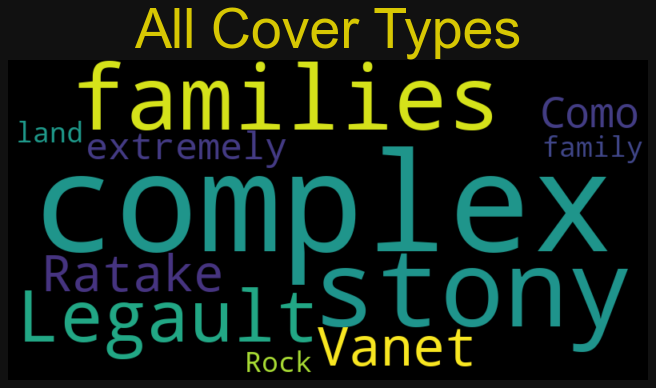

Description by Cover Type


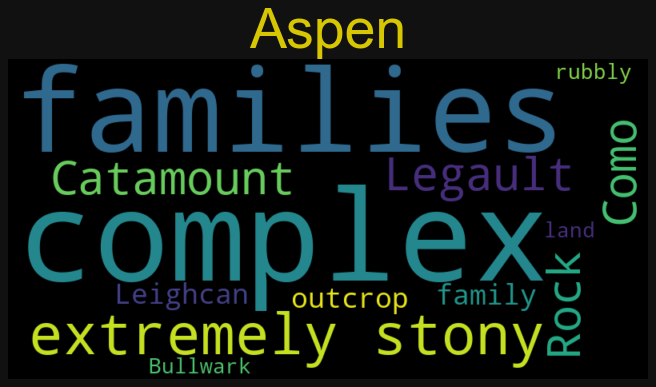

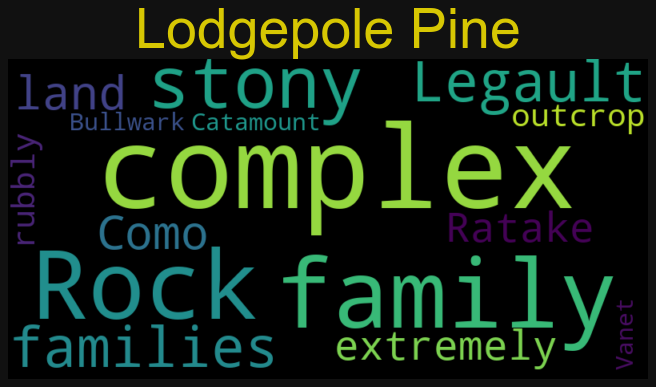

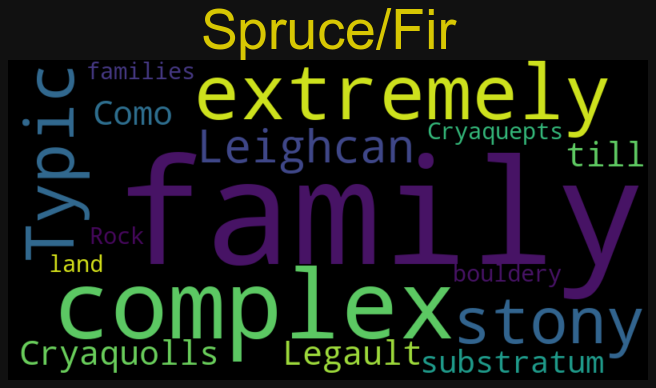

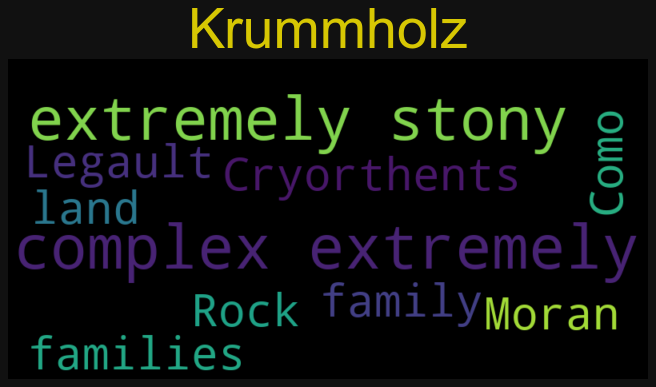

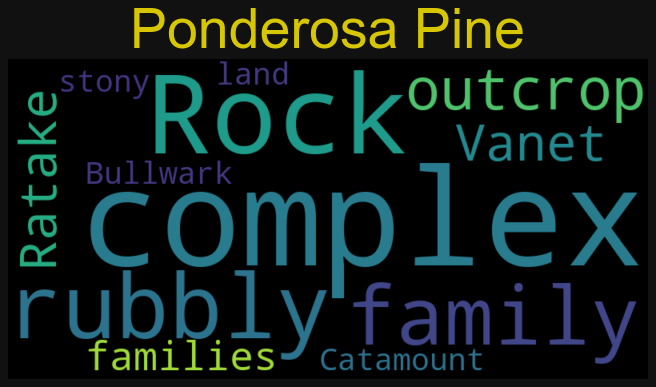

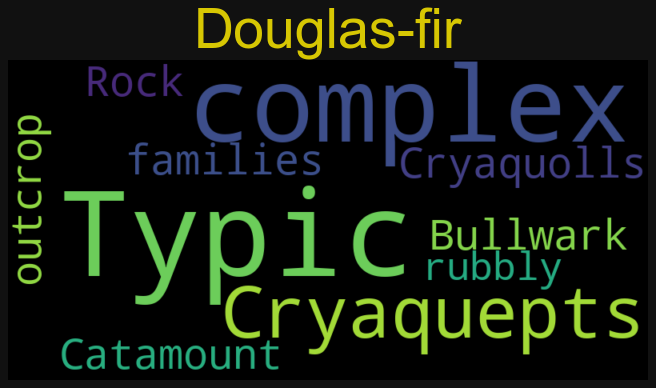

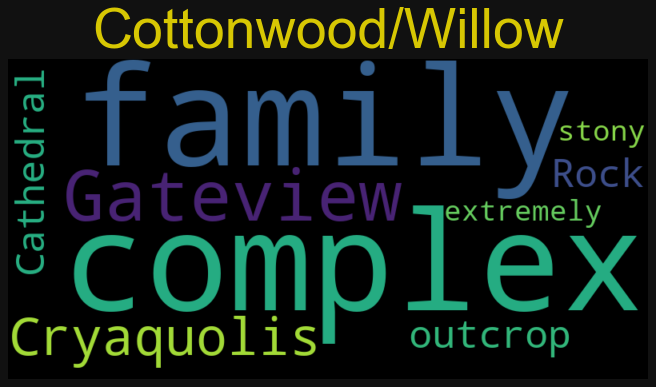

In [25]:
stopwords = set(STOPWORDS)
size = (6,3)

def cloud(text, title, stopwords=stopwords, size=size):
    """
    Function to plot WordCloud
    Includes: 
    """
    # Setting figure parameters
    mpl.rcParams['figure.figsize']=(10.0,10.0)
    mpl.rcParams['font.size']=12
    mpl.rcParams['savefig.dpi']=100
    mpl.rcParams['figure.subplot.bottom']=.1 
    
    # Processing Text
    # Redundant when combined with my Preprocessing function
    wordcloud = WordCloud(width=800, height=400,
                          background_color='black',
                          stopwords=stopwords,
                         ).generate(str(text))
    
   # Output Visualization
    fig = plt.figure(figsize=size, dpi=80, facecolor='k',edgecolor='k')
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=50,color='y')
    plt.tight_layout(pad=0)
    plt.show()
print("Word Cloud Function Done")

# Data Set for Word Clouds
cloud_df = pd.concat([df.loc[traindex,'description'], y_trees],axis=1)
cloud(df["description"].values, title="All Cover Types", size=[8,5])

print("Description by Cover Type")
cloud_df = pd.concat([df.loc[traindex,'description'], y_trees],axis=1)
for cover in cloud_df.Cover_Type.unique():
    cloud(cloud_df.loc[cloud_df.Cover_Type == cover, "description"].values, title="{}".format(cover), size=[8,5])

Lathwal Features:

In [26]:
# Features By Lathwal - Source: https://www.kaggle.com/codename007/forest-cover-type-eda-baseline-model
df['HF1'] = df['Horizontal_Distance_To_Hydrology']+df['Horizontal_Distance_To_Fire_Points']
df['HF2'] = abs(df['Horizontal_Distance_To_Hydrology']-df['Horizontal_Distance_To_Fire_Points'])
df['HR1'] = abs(df['Horizontal_Distance_To_Hydrology']+df['Horizontal_Distance_To_Roadways'])
df['HR2'] = abs(df['Horizontal_Distance_To_Hydrology']-df['Horizontal_Distance_To_Roadways'])
df['FR1'] = abs(df['Horizontal_Distance_To_Fire_Points']+df['Horizontal_Distance_To_Roadways'])
df['FR2'] = abs(df['Horizontal_Distance_To_Fire_Points']-df['Horizontal_Distance_To_Roadways'])

In [27]:
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Hillshade-noon_3pm_diff,Hillshade-9am_3pm_diff,Slope*Elevation,description,HF1,HF2,HR1,HR2,FR1,FR2
Id,,,,,,,,,,,,,,,,,,,,,
1,2596,51,3,258,0,510,221,232,148,6279,...,84,73,7788,...,6537,6021,768,252,6789,5769
2,2590,56,2,212,-6,390,220,235,151,6225,...,84,69,5180,...,6437,6013,602,178,6615,5835
3,2804,139,9,268,65,3180,234,238,135,6121,...,103,99,25236,Legault family - Rock la...,6389,5853,3448,2912,9301,2941
4,2785,155,18,242,118,3090,238,238,122,6211,...,116,116,50130,...,6453,5969,3332,2848,9301,3121
5,2595,45,2,153,-1,391,220,234,150,6172,...,84,70,5190,...,6325,6019,544,238,6563,5781


In [29]:
df['description']

Id
1                                                       ...
2                                                       ...
3                               Legault family - Rock la...
4                                                       ...
5                                                       ...
                                ...                        
581008      Vanet - Ratake families complex, very stony....
581009      Vanet - Ratake families complex, very stony....
581010      Vanet - Ratake families complex, very stony....
581011      Vanet - Ratake families complex, very stony....
581012      Vanet - Ratake families complex, very stony....
Name: description, Length: 581012, dtype: object

In [31]:
df['description'].tail(1).values

array(['  Vanet - Ratake families complex, very stony.                                                                            '],
      dtype=object)

### Train and Test Data Split

In [32]:
# Clean up and add TFIDF features
df.drop("description", axis = 1, inplace=True)
non_text_cols = df.columns
df = pd.concat([df,df1], axis= 1)
del df1

In [33]:
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,vanet wetmore,vanet wetmore families,warm,warm extremely,warm extremely stony,warm rock,warm rock outcrop,wetmore,wetmore families,wetmore families rock
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
# Modeling Datasets
train_df = df.loc[traindex,:]
test_df = df.loc[testdex,:]
vocab = df.columns

In [35]:
y

Id
1        5
2        5
3        2
4        2
5        5
        ..
15116    3
15117    3
15118    3
15119    3
15120    3
Name: Cover_Type, Length: 15120, dtype: int64

In [36]:
# Has to start at zero for some reason
y = y - 1

In [37]:
y

Id
1        4
2        4
3        1
4        1
5        4
        ..
15116    2
15117    2
15118    2
15119    2
15120    2
Name: Cover_Type, Length: 15120, dtype: int64

In [40]:
vocab

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points',
       ...
       'vanet wetmore', 'vanet wetmore families', 'warm', 'warm extremely',
       'warm extremely stony', 'warm rock', 'warm rock outcrop', 'wetmore',
       'wetmore families', 'wetmore families rock'],
      dtype='object', length=299)

In [41]:
# LGBM Dataset
lgtrain = lgb.Dataset(df.loc[traindex,vocab],y, categorical_feature= "auto")
print("Starting LightGBM.\nTrain shape: {}\nTest shape: {}".format(train_df.shape,test_df.shape))
print("Feature Num: ",len(vocab))
print("\nDtypes in Model:\n",df.dtypes.value_counts())
del df; gc.collect();

Starting LightGBM.
Train shape: (15120, 299)
Test shape: (565892, 299)
Feature Num:  299

Dtypes in Model:
 float32    235
float64     64
dtype: int64


### TSNE

In [42]:
y_trees

Id
1                 Aspen
2                 Aspen
3        Lodgepole Pine
4        Lodgepole Pine
5                 Aspen
              ...      
15116    Ponderosa Pine
15117    Ponderosa Pine
15118    Ponderosa Pine
15119    Ponderosa Pine
15120    Ponderosa Pine
Name: Cover_Type, Length: 15120, dtype: object

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

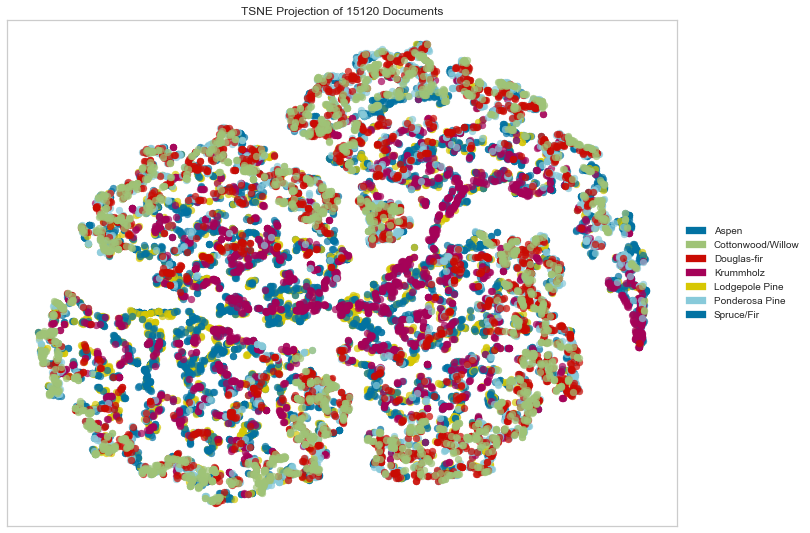

<AxesSubplot:title={'center':'TSNE Projection of 15120 Documents'}>

In [43]:
# Create the visualizer and draw the vectors
plt.figure(figsize = [15,9])
tsne = TSNEVisualizer()
tsne.fit(train_df, y_trees)
tsne.poof()

### [EDA] Continuous Variable Distribution by Cover Type  
- Out of these distributions, elevation is definitely the most desisive

In [45]:
train_df.nunique()

Elevation                           1665
Aspect                               361
Slope                                 52
Horizontal_Distance_To_Hydrology     400
Vertical_Distance_To_Hydrology       423
                                    ... 
warm rock                              2
warm rock outcrop                      2
wetmore                                2
wetmore families                       2
wetmore families rock                  2
Length: 299, dtype: int64

In [46]:
train_df.nunique().reset_index()

,index,0
0,Elevation,1665
1,Aspect,361
2,Slope,52
3,Horizontal_Distance_To_Hydrology,400
4,Vertical_Distance_To_Hydrology,423
...,...,...
294,warm rock,2
295,warm rock outcrop,2
296,wetmore,2
297,wetmore families,2


In [47]:
# Seperating Variables by Number of Unique Values
df_nnunique = train_df.nunique().reset_index().rename(columns = {"index": "cols",0:"unique_num"})

In [48]:
df_nnunique.head()

,cols,unique_num
0,Elevation,1665
1,Aspect,361
2,Slope,52
3,Horizontal_Distance_To_Hydrology,400
4,Vertical_Distance_To_Hydrology,423


In [49]:
binary = list(df_nnunique.loc[df_nnunique.unique_num <= 2, "cols"])
continuous = list(df_nnunique.loc[df_nnunique.unique_num > 10, "cols"])
few_categories = list(df_nnunique.loc[(df_nnunique.unique_num >= 3)
                                      & (df_nnunique.unique_num <= 10) , "cols"])

In [50]:
print("Number of Binary Variables: ", len(binary)-1)
print("Number of Continous Variables: ", len(continuous)-1)
print("Number of Non-Binary, Categorical Variables: ", len(few_categories))

Number of Binary Variables:  201
Number of Continous Variables:  31
Number of Non-Binary, Categorical Variables:  65


In [51]:
pd.concat([train_df.loc[:,continuous],y_trees],axis=1)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,extremely,extremely stony,families,family,leighcan,outcrop,rock,rock outcrop,stony,Cover_Type
Id,,,,,,,,,,,,,,,,,,,,,
1,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.179728,0.191445,0.221371,0.000000,0.0,0.000000,0.000000,0.000000,0.174375,Aspen
2,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.000000,0.000000,0.000000,0.153055,0.0,0.000000,0.162434,0.000000,0.127912,Aspen
3,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.107144,0.114129,0.000000,0.210604,0.0,0.000000,0.132008,0.000000,0.103953,Lodgepole Pine
4,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.179728,0.191445,0.221371,0.000000,0.0,0.000000,0.000000,0.000000,0.174375,Lodgepole Pine
5,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.179728,0.191445,0.221371,0.000000,0.0,0.000000,0.000000,0.000000,0.174375,Aspen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15116,2607.0,243.0,23.0,258.0,7.0,660.0,170.0,251.0,214.0,1282.0,...,0.000000,0.000000,0.000000,0.141179,0.0,0.190007,0.149830,0.190007,0.000000,Ponderosa Pine
15117,2603.0,121.0,19.0,633.0,195.0,618.0,249.0,221.0,91.0,1325.0,...,0.000000,0.000000,0.000000,0.141179,0.0,0.190007,0.149830,0.190007,0.000000,Ponderosa Pine
15118,2492.0,134.0,25.0,365.0,117.0,335.0,250.0,220.0,83.0,1187.0,...,0.000000,0.000000,0.000000,0.141179,0.0,0.190007,0.149830,0.190007,0.000000,Ponderosa Pine


In [52]:
target_var

'Cover_Type'

In [53]:
melt_df = pd.melt(pd.concat([train_df.loc[:,continuous],y_trees],axis=1), id_vars=target_var)

In [54]:
melt_df

,Cover_Type,variable,value
0,Aspen,Elevation,2596.000000
1,Aspen,Elevation,2590.000000
2,Lodgepole Pine,Elevation,2804.000000
3,Lodgepole Pine,Elevation,2785.000000
4,Aspen,Elevation,2595.000000
...,...,...,...
483835,Ponderosa Pine,stony,0.000000
483836,Ponderosa Pine,stony,0.000000
483837,Ponderosa Pine,stony,0.000000
483838,Ponderosa Pine,stony,0.098611


In [57]:
15120*32 

483840

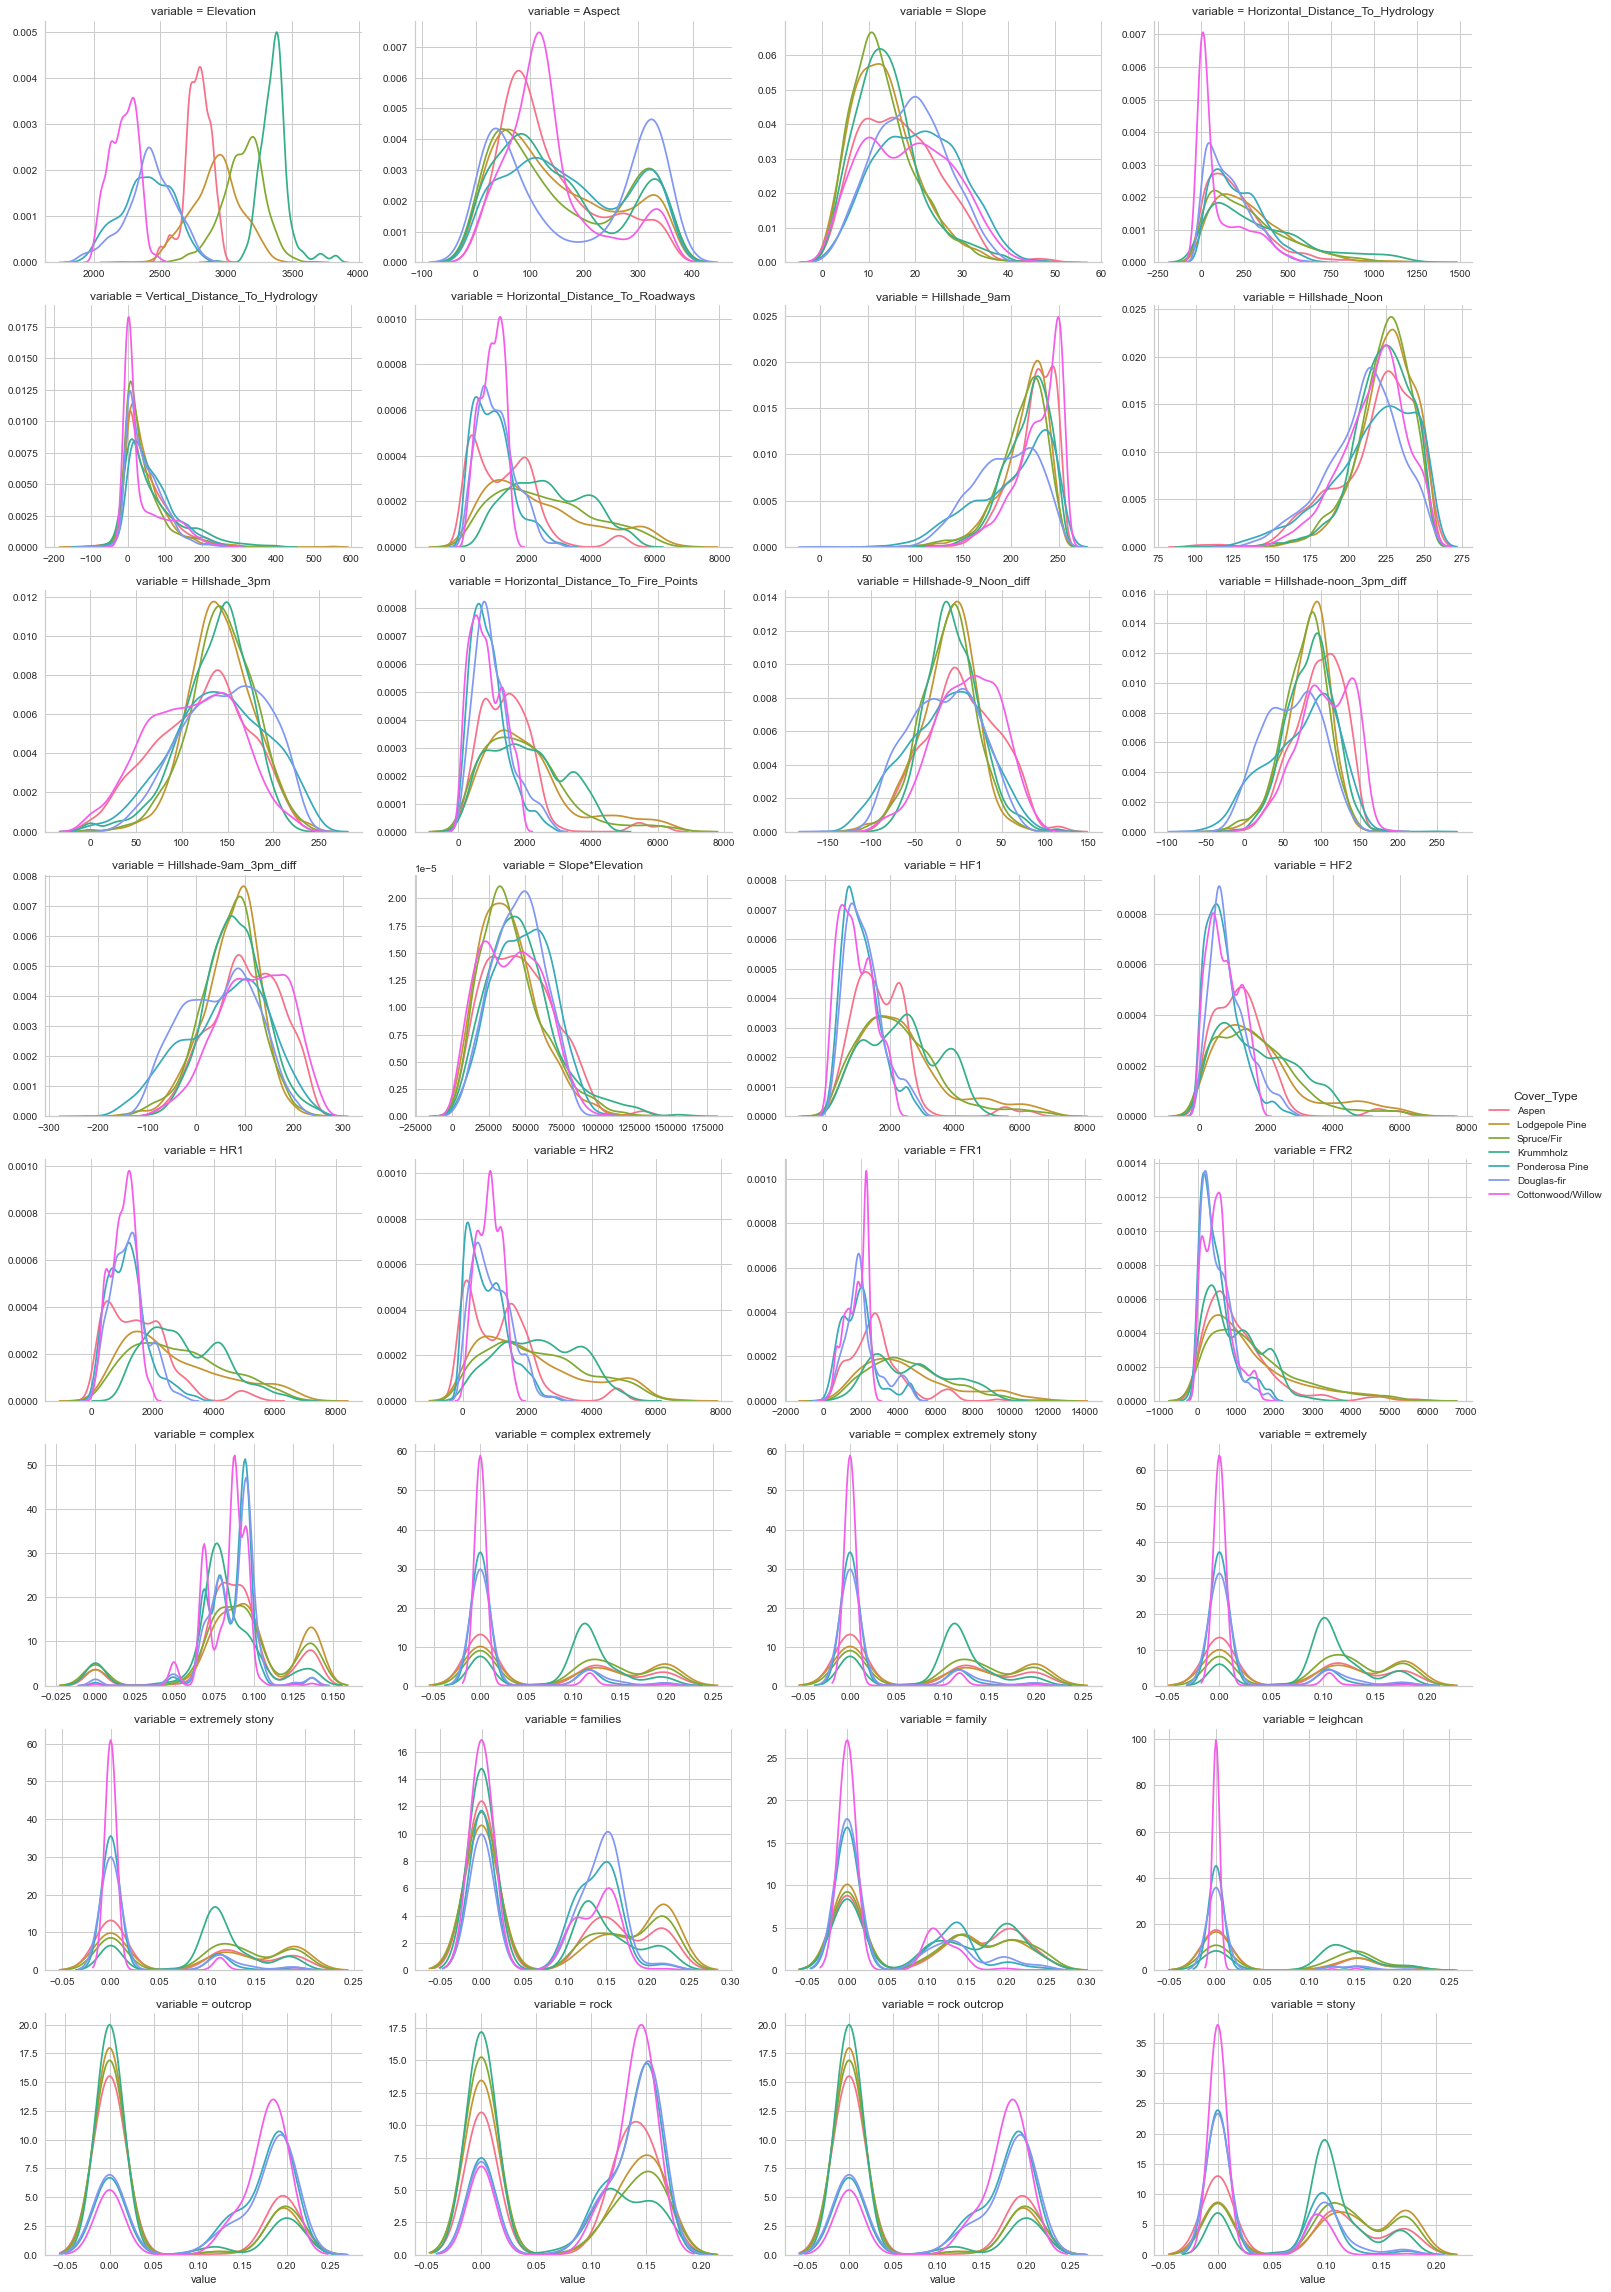

In [59]:
grid = sns.FacetGrid(melt_df,col="variable", hue=target_var, col_wrap=4 , size=4.0, aspect=1.3, sharex=False, sharey=False)
grid.map(sns.kdeplot, "value")
grid.set_titles(size=12)
grid.add_legend();
plt.show()

In [60]:
def rank_correlations(df, figsize=(12,20), n_charts = 18, polyorder = 2, asc = False):
    # Rank Correlations
    continuous_rankedcorr = (df
                             .corr()
                             .unstack()
                             .sort_values(ascending=asc)
                             .drop_duplicates().reset_index())
    continuous_rankedcorr.columns = ["f1","f2","Absoluate Correlation Coefficient"]   

    # Plot Top Correlations
    top_corr = [(x,y) for x,y in list(continuous_rankedcorr.iloc[:, 0:2].values) if x != y]
    f, axes = plt.subplots(int(n_charts/3),3, figsize=figsize, sharex=False, sharey=False)
    row = 0
    col = 0
    for (x,y) in top_corr[:n_charts]:
        if col == 3:
            col = 0
            row += 1
        g = sns.regplot(x=x, y=y, data=df, order=polyorder, ax = axes[row,col])
        axes[row,col].set_title('Correlation for\n{} and\n{}'.format(x, y))
        col += 1
    plt.tight_layout(pad=0)
    plt.show()
print("rank_correlations Plot Function Ready..")

rank_correlations Plot Function Ready..


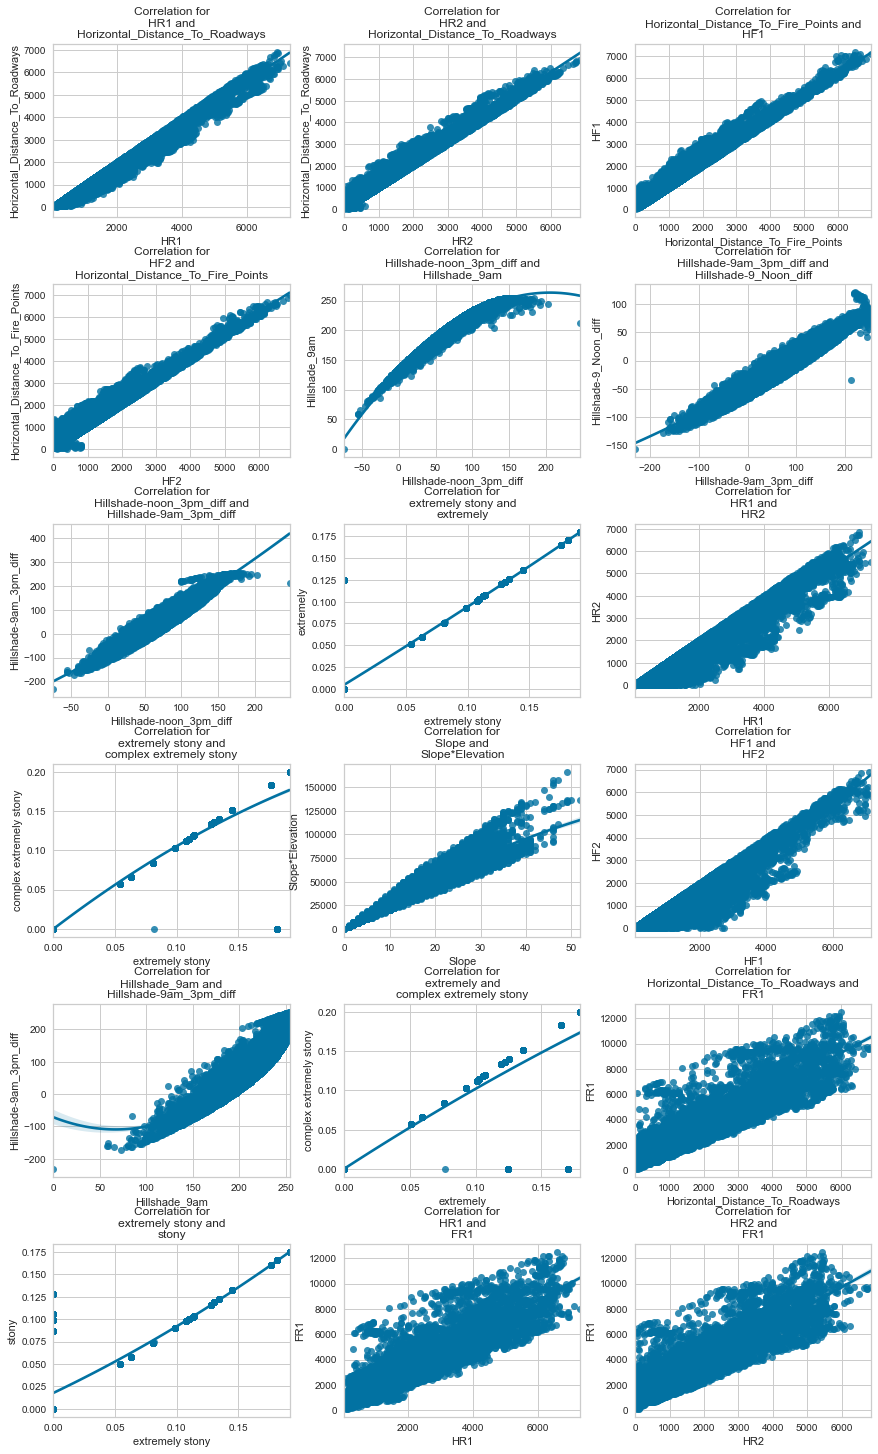

In [61]:
rank_correlations(df = train_df.loc[traindex,continuous])

### [EDA] Binary Variable Distribution by Cover Type

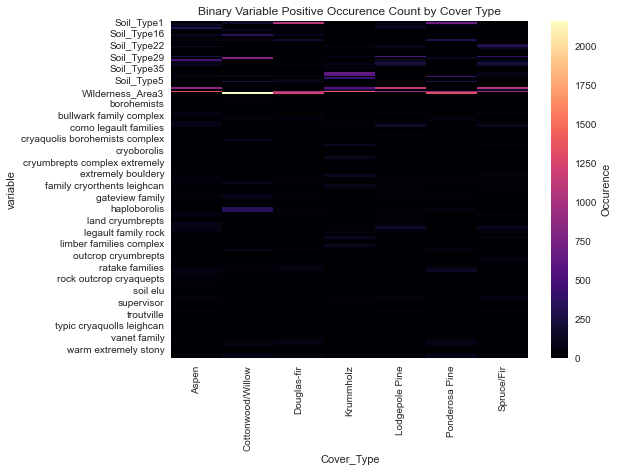

In [62]:
# Melt
melt_df = pd.melt(pd.concat([train_df.loc[:,binary].astype("category"),y_trees],axis=1), id_vars=target_var)
binary_data = pd.pivot_table(melt_df, values="value", index="variable",columns=["Cover_Type"], aggfunc = np.sum)

f, ax = plt.subplots(figsize=[8,6])
sns.heatmap(binary_data, annot=False, fmt=".2f",cbar_kws={'label': 'Occurence'},cmap="magma",ax=ax)
ax.set_title("Binary Variable Positive Occurence Count by Cover Type")
plt.show()

### Modeling Stage

#### Cross validation 

Hand Tuning

In [63]:
print("Light Gradient Boosting Classifier: ")
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 7,
    'metric': ['multi_error'],
    "learning_rate": 0.05,
     "num_leaves": 60,
     "max_depth": 9,
     "feature_fraction": 0.45,
     "bagging_fraction": 0.3,
     "reg_alpha": 0.15,
     "reg_lambda": 0.15,
#      "min_split_gain": 0,
      "min_child_weight": 0
                }

Light Gradient Boosting Classifier: 


In [64]:
lgtrain

In [66]:
# Find Optimal Parameters / Boosting Rounds
lgb_cv = lgb.cv(params = lgbm_params, train_set = lgtrain, num_boost_round=2000,
                stratified=True, nfold = 5, verbose_eval=50, seed = 23, early_stopping_rounds=75)

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5331
[LightGBM] [Info] Number of data points in the train set: 12096, number of used features: 244
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5331
[LightGBM] [Info] Number of data points in the train set: 12096, number of used features: 244
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5331
[LightGBM] [Info] Number of data points in the train set: 12096, number of used features: 244
[LightGBM] [Warning] Auto-choosing col-wi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LightGBMError: Check failed: (best_split_info.left_count) > (0) at D:\a\1\s\python-package\compile\src\treelearner\serial_tree_learner.cpp, line 653 .


# 이상 ... 다시 해볼 것...